In [1]:
import trainExplainer
import importlib
import datasetLoader
import evaluation
import torch
import explainer
import networks
import wandb

importlib.reload(trainExplainer)
importlib.reload(datasetLoader)

<module 'datasetLoader' from 'c:\\Users\\trist\\Git_repos\\BT-ML-PGESAT\\code\\PGExplainer\\datasetLoader.py'>

In [8]:
sweep_config = {
    "method": 'grid',                    # random, grid or Bayesian search
    "metric": {"goal": "maximize", "name": "val/mean_AUC"},
    "parameters": {
        'tT': {
            'values': [1.0, 5.0]
            },
        'size_reg': {
            'values': [0.0001, 0.01, 0.1]
            },
        'entropy_reg': {
            'values': [0.0001, 0.01, 0.1, 1.0, 10.0]
            },
        'lr_mlp':{
            'values': [0.003, 0.001, 0.0001]
            },
    },
}   

In [ ]:
'L2_reg': {
            'values': [0.0, 0.01, 0.1, 1.0]
            },

In [9]:
sweep_id = wandb.sweep(sweep_config, project="Sweep-Tree-Cycles")

Create sweep with ID: t6yaa3nc
Sweep URL: https://wandb.ai/tristan-schulz2001-tu-dortmund/Sweep-Tree-Cycles/sweeps/t6yaa3nc


In [2]:
dataset="BA-2Motif"

In [ ]:
wandb.agent(sweep_id, trainExplainer.trainExplainer)

In [3]:
# TODO: Probably best to load data here once and pass to each task?
importlib.reload(evaluation)

mlp, downstreamTask = trainExplainer.trainExplainer(dataset=dataset, save_model=False)

wandb: Currently logged in as: tristan-schulz2001 (tristan-schulz2001-tu-dortmund) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Evaluation downstream task before training: 1.0
tensor(0)
Epoch 1, Loss: 0.2617425322532654
BinaryAUROC: 0.09341253839200139
roc_auc_score: 0.09341253839200139
model.0.weight: tensor([[-2.4039e-05, -5.2696e-05, -6.6177e-06,  ..., -1.1333e-06,
          0.0000e+00, -1.4758e-05],
        [ 1.1196e-04,  1.2009e-06,  1.6333e-05,  ...,  9.7579e-06,
          1.9015e-05,  6.4030e-06],
        [-8.9772e-04, -2.0856e-05, -5.2034e-05,  ..., -2.8980e-05,
         -1.0215e-06, -3.1972e-05],
        ...,
        [ 2.6139e-04,  5.7429e-05,  3.9313e-06,  ...,  2.9187e-06,
          3.9842e-05,  2.8035e-06],
        [ 2.6572e-04,  1.2986e-05,  2.6086e-07,  ...,  3.3961e-08,
          1.6076e-05,  1.2148e-06],
        [ 5.2618e-04,  9.8578e-07,  4.9810e-05,  ...,  1.4481e-05,
          0.0000e+00,  1.8355e-05]])
Weight: model.0.weight: Parameter containing:
tensor([[ 0.0121,  0.0304, -0.2077,  ..., -0.1298, -0.1727,  0.1504],
        [-0.1996, -0.1788,  0.2341,  ...,  0.1970, -0.0273,  0.0027],
      

train/Loss,▆▇▆▅▇▆▅▅▅▄██▅▅▇▄▃▁▁▅
val/mean_AUC,▅▂▁▁▂▂▃▅▅▅▆▆▆▆▇▇▇▇██
val/sum_sampledEdges,████▇▇▇▇▆▆▆▅▅▅▄▃▃▂▂▁
val/temperature,█▇▇▆▆▅▅▄▄▃▃▃▂▂▂▂▂▁▁▁
train/Loss,0.22195
val/mean_AUC,0.11225
val/sum_sampledEdges,7299.28271
val/temperature,1


Evaluation downstream task after training: 1.0


In [ ]:
torch.save(mlp.state_dict(), f"models/explainer-BA-Community-81")

In [ ]:
mlp, downstramTask = trainExplainer.loadExplainer(dataset=dataset)

BinaryAUROC: 0.5921905484429003
roc_auc_score: 0.5921905484429003
-----------------Original Graph-----------------


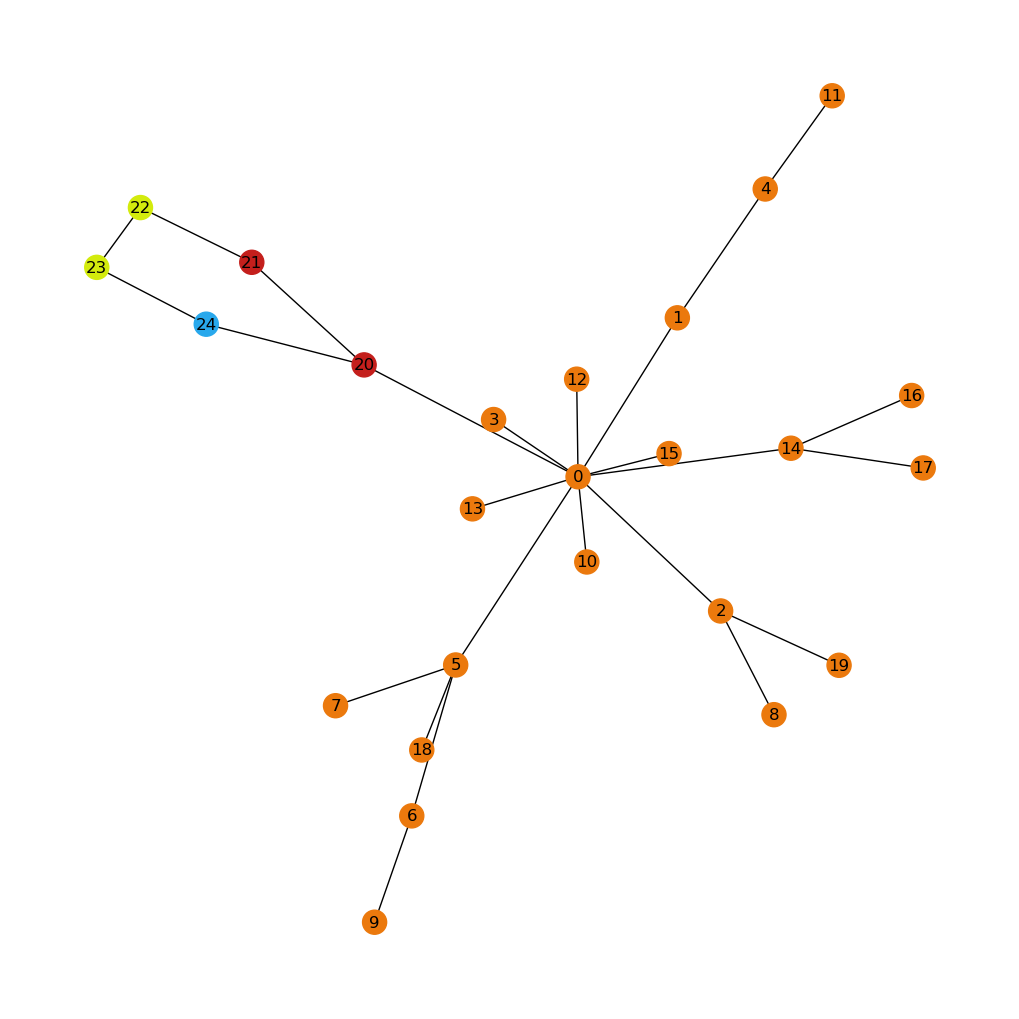

-----------Original Graph with edge weights-----------


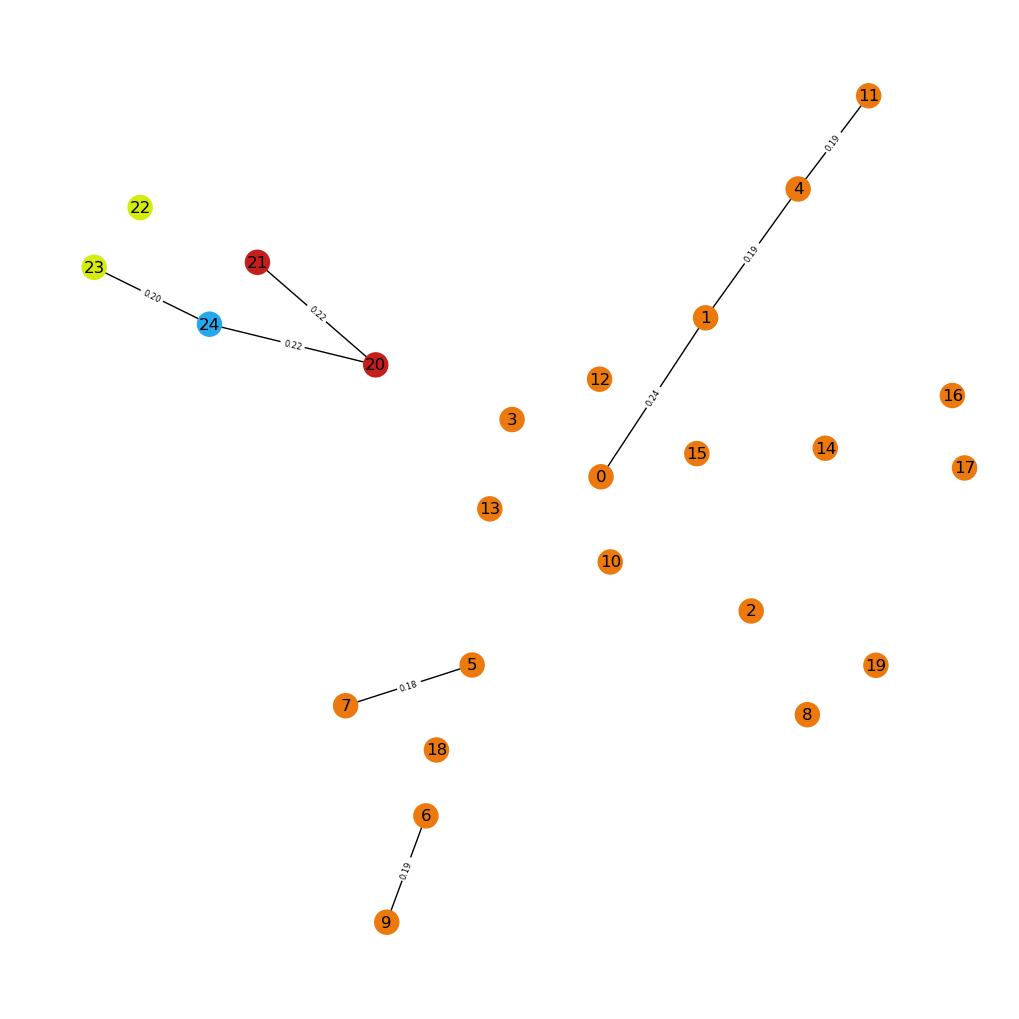

-----------------Explanation Graph-----------------


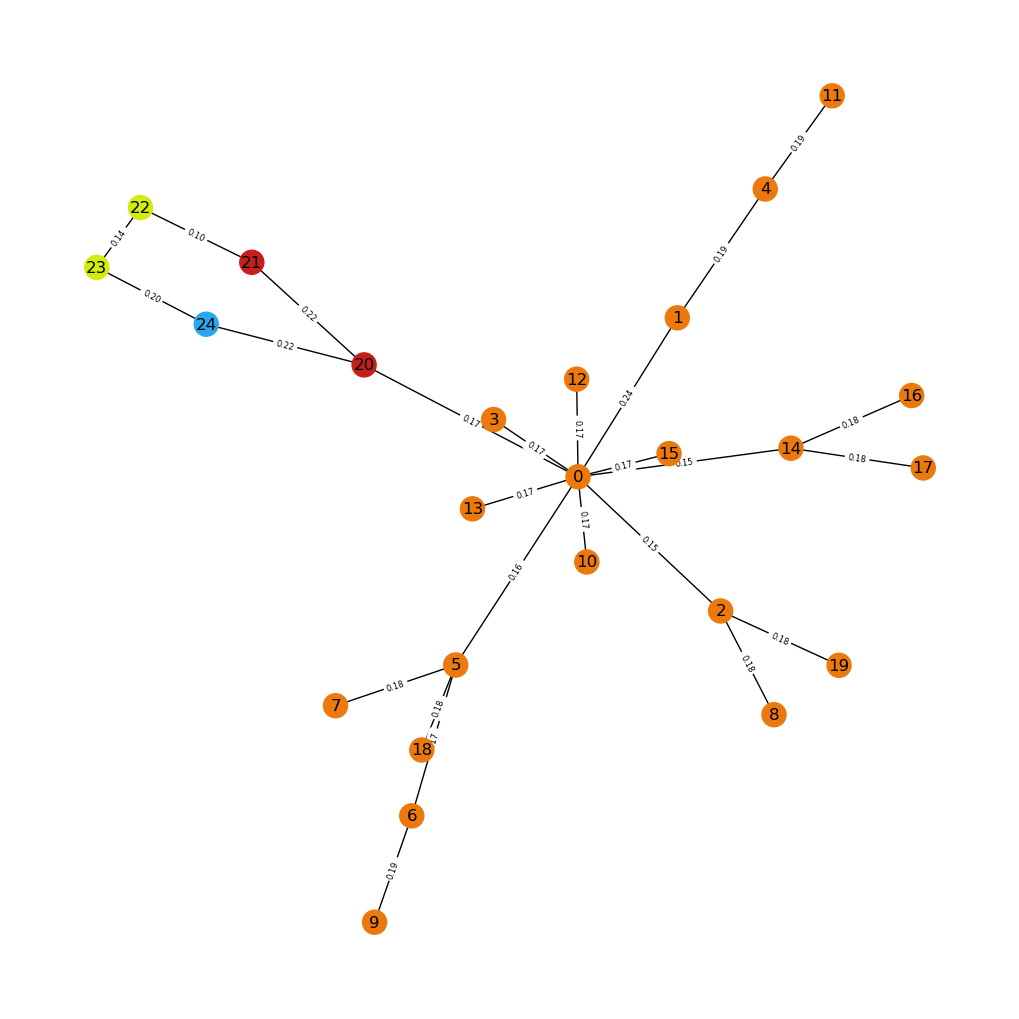

-----------------Ground truth Graph-----------------


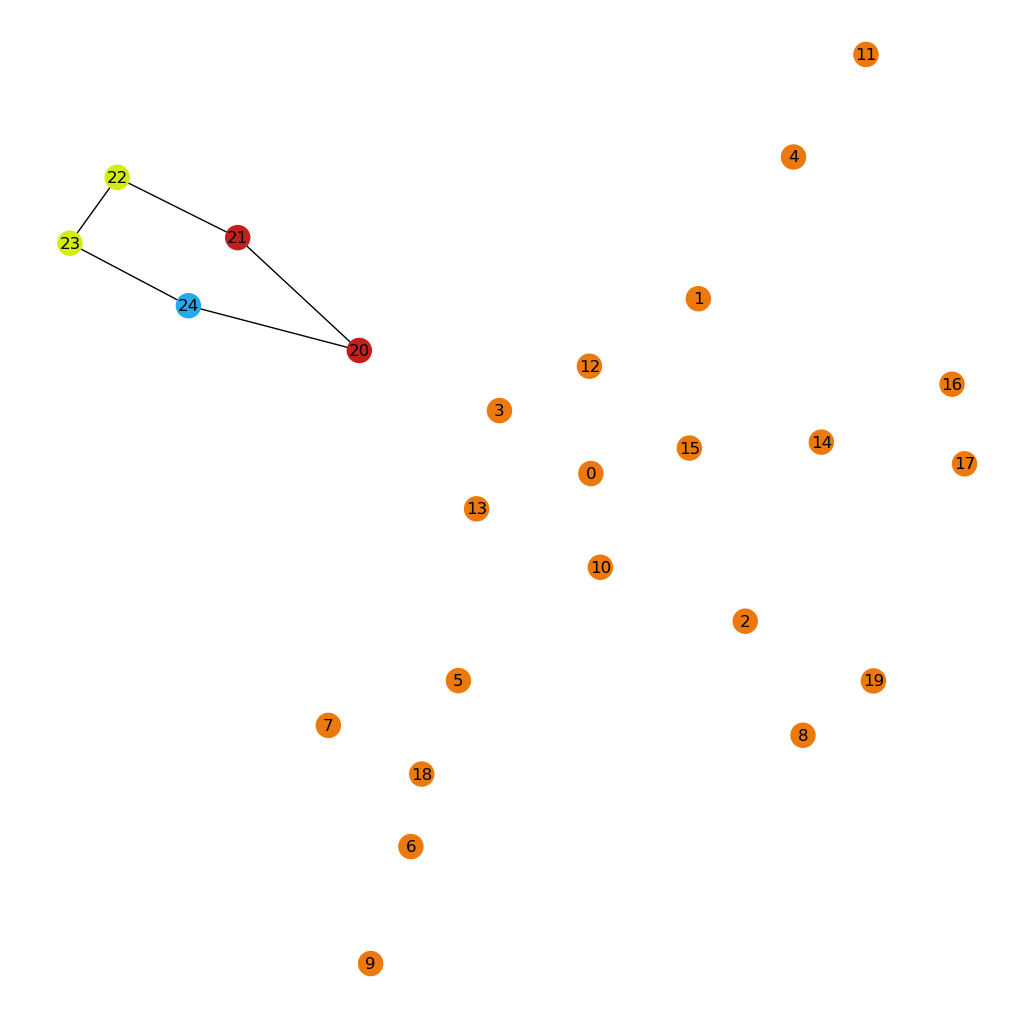

Mean AUC for evaluation: 0.5921905484429003


In [4]:
importlib.reload(evaluation)

auc = evaluation.evaluate(datasetName=dataset, mlp=mlp, downstreamTask=downstreamTask)

print(f"Mean AUC for evaluation: {auc}")

In [8]:
import wandb
wandb.finish()

In [10]:
import utils
import torch
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data

In [14]:
data, labels = datasetLoader.loadOriginalNodeDataset("BA-Shapes")
graph_dataset_seed = 42
generator1 = torch.Generator().manual_seed(graph_dataset_seed)
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(data, [0.8, 0.1, 0.1], generator1)

c:\Users\trist\anaconda3\Lib\site-packages\torch\utils\data\dataset.py:473: UserWarning: Length of split at index 2 is 0. This might result in an empty dataset.
  warnings.warn(


In [16]:
k = 5

data1 = data

printLoader = DataLoader([data1], 1, False)

temperature = 1

In [17]:
mlp.eval()
downstreamTask.eval()

w_ij = mlp.forward(downstreamTask, data1.x, data1.edge_index)

print(w_ij)

edge_ij = mlp.sampleGraph(w_ij)
print(edge_ij)

_, top_k_indices = torch.topk(edge_ij, k=k*2, largest=True)

mask = torch.zeros_like(edge_ij, dtype=torch.bool)
mask[top_k_indices] = True

sortedTopK, indices = torch.sort(top_k_indices)

edge_index_masked = data1.edge_index[:,mask]
weights_masked = edge_ij[sortedTopK]                # This is ordered by size

# edge_index_masked and weights_masked to display top 5 edges; data1.edge_index and w_ij to display original graph
Gs = Data(x=data1.x, edge_index=edge_index_masked, edge_attr=weights_masked)

#print(Gs.edge_attr)
#print(weights_masked)

print("-----------------Original Graph-----------------")

#pos = utils.plotGraph(data1, MUTAG=MUTAG)
pos = utils.plotGraphAll(data1, number_nodes=True, graph_task=True)

print("-----------------Sampled Graph-----------------")

#pos1 = utils.plotGraph(Gs, pos=pos, color_map=None, edge_weights=True, MUTAG=MUTAG)
pos1 = utils.plotGraphAll(Gs, pos=pos, number_nodes=True, graph_task=True, edge_weights=True)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (4110x120 and 180x64)

In [18]:
data, labels = datasetLoader.loadOriginalNodeDataset("BA-Shapes")
graph_dataset_seed = 42
generator1 = torch.Generator().manual_seed(graph_dataset_seed)
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(data, [0.8, 0.1, 0.1], generator1)

c:\Users\trist\anaconda3\Lib\site-packages\torch\utils\data\dataset.py:473: UserWarning: Length of split at index 2 is 0. This might result in an empty dataset.
  warnings.warn(


In [23]:
import random
import evaluation
from torch_geometric.utils import k_hop_subgraph

motifNodesOriginal = [i for i in range(400,700,5)]

randomAUCNode = random.choice(motifNodesOriginal)
currentAUC = randomAUCNode

AUC of ROC: 0.9920886158943176
BinaryAUROC: 0.9920886075949367
roc_auc_score: 0.9920886075949368
0.9920886075949368


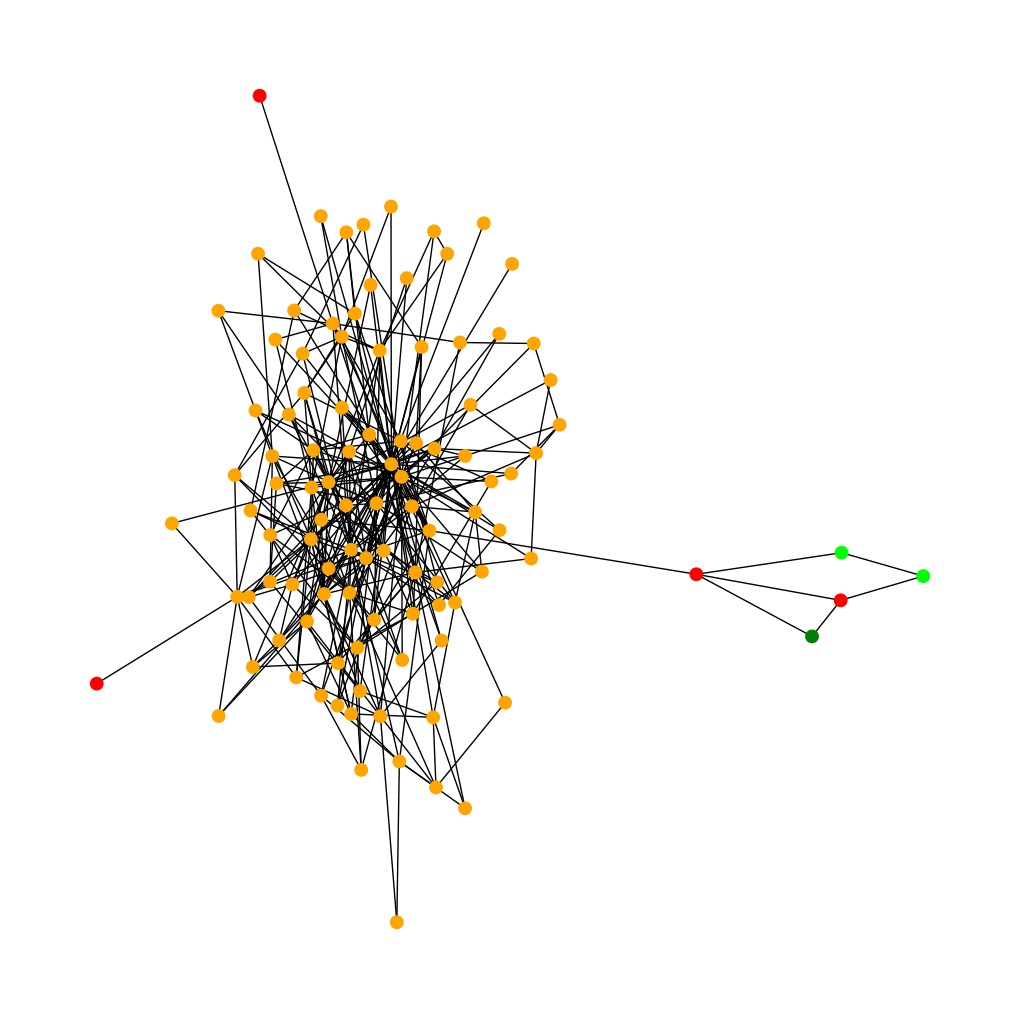

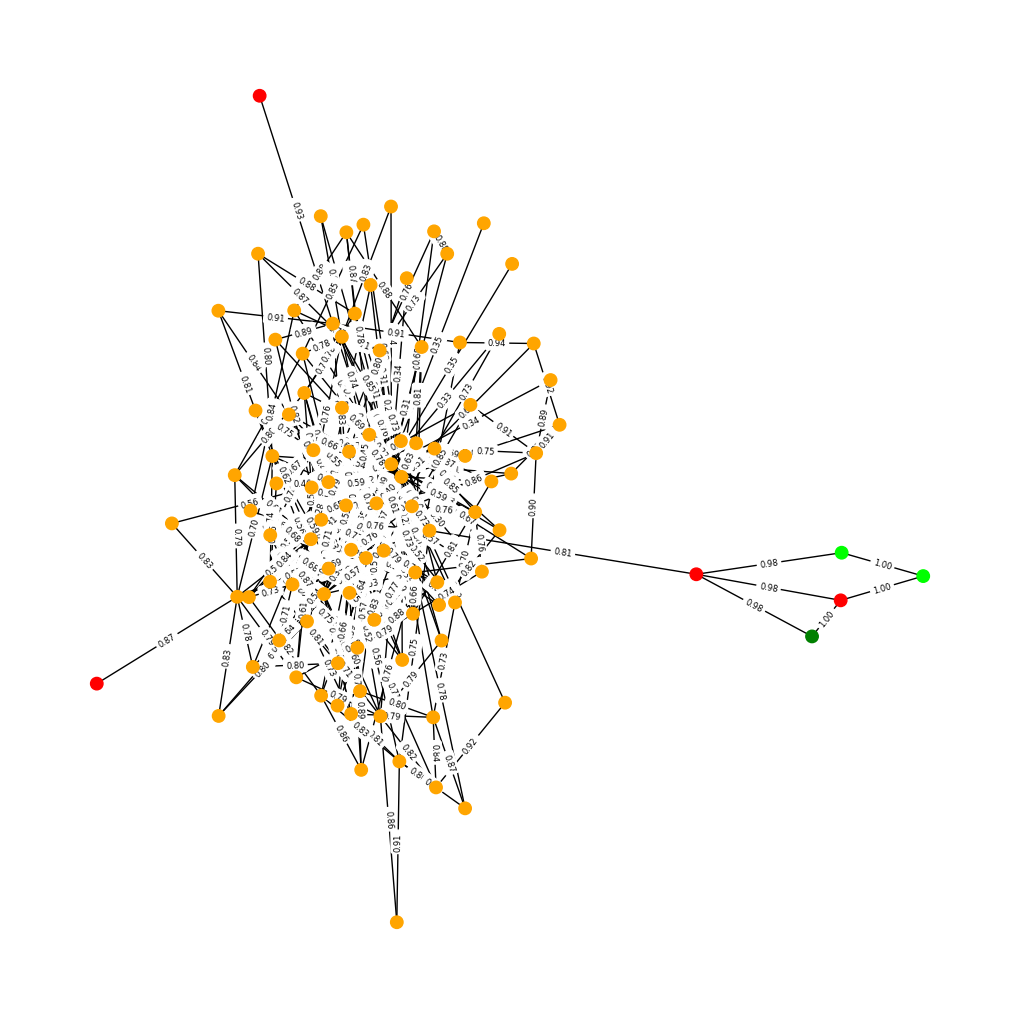

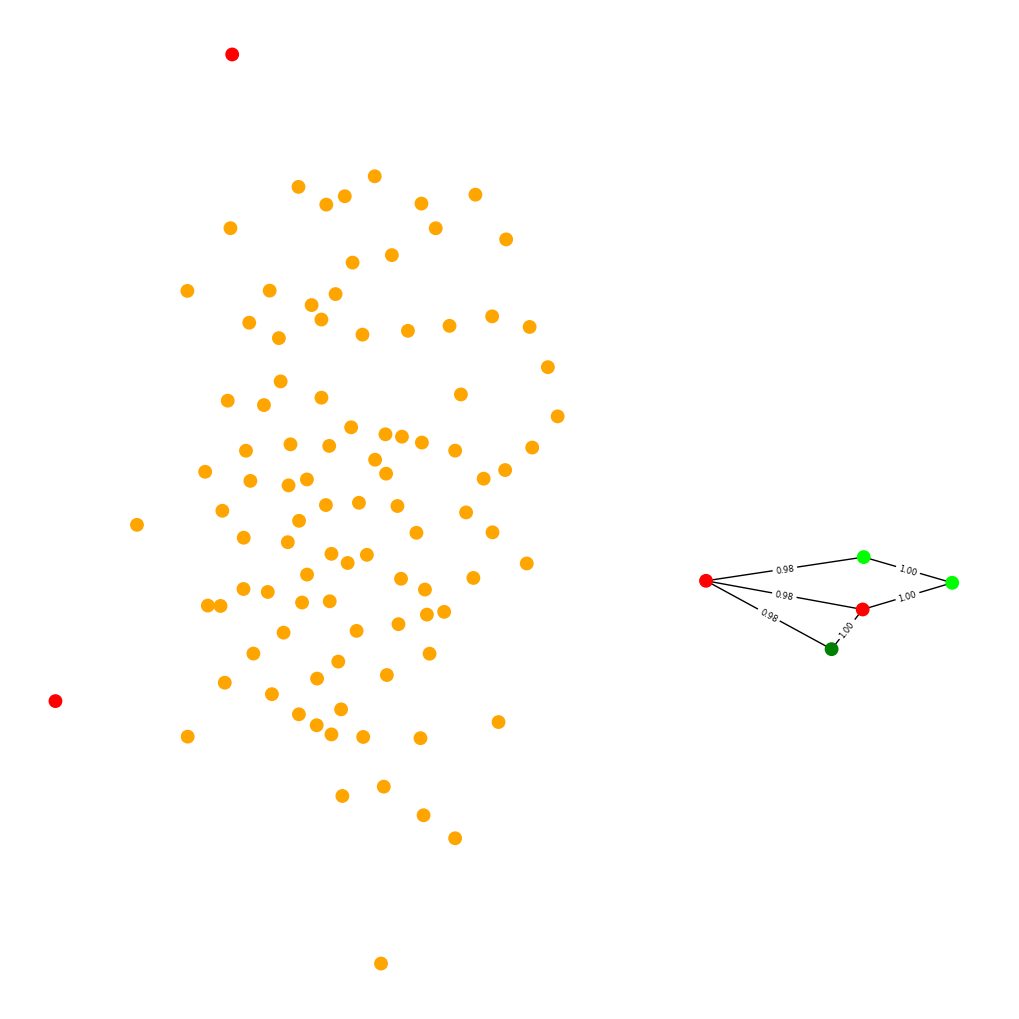

In [24]:
k = 6

mlp.eval()
downstreamTask.eval()

#AUCNode = [i for i in range(511,871,6)]
#AUCNode = [i for i in range(a[0].item(),a[len(a)-1]+1,6)]

#print(data.edge_index)

print(evaluation.evaluateNodeExplainerAUC(mlp, downstreamTask, data, data.edge_index, currentAUC, data.gt, k=k))

subset, edge_index_hop, mapping, edge_mask = k_hop_subgraph(node_idx=currentAUC, num_hops=3, edge_index=data.edge_index, relabel_nodes=True)

indexNodeToPred = (subset == currentAUC).nonzero().item()

G_hop = Data(x=data.x[subset], edge_index=edge_index_hop, y=data.y[subset])

pos = utils.plotGraphAll(G_hop)




w_ij = mlp.forward(downstreamTask, data.x[subset], edge_index_hop, indexNodeToPred)

# Min-Max Normalization. This works pretty well
weights_min = w_ij.min()
weights_max = w_ij.max()
weights_norm = (w_ij - weights_min) / (weights_max - weights_min)

#print(torch.unique(w_ij))
edge_ij = mlp.sampleGraph(w_ij, temperature)

## REMOVE IF SIGMOID WANTED
edge_ij = weights_norm


GraphSampled = Data(x=G_hop.x, edge_index=G_hop.edge_index, y=G_hop.y, edge_attr=edge_ij.detach())

pos = utils.plotGraphAll(GraphSampled, pos, edge_weights=True)


# Print topK edges
k = k * 2 if len(w_ij) >= k*2 else len(w_ij)
_, top_k_indices = torch.topk(edge_ij, k=k, largest=True)

mask = torch.zeros_like(edge_ij, dtype=torch.bool)
mask[top_k_indices] = True

sortedTopK, indices = torch.sort(top_k_indices)

edge_index_masked = G_hop.edge_index[:,mask]
weights_masked = edge_ij[sortedTopK]                # This is ordered by size

GtopK = Data(x=G_hop.x, edge_index=edge_index_masked, y=G_hop.y, edge_attr=weights_masked)

pos1 = utils.plotGraphAll(GtopK, pos=pos, color_map=None, edge_weights=True)